# Ejemplo de LSTM sencilla con pytorch

Vamos a escribir el código necesario para hacer una LSTM con pytorch y probarla con un dataset sencillo.

## Generación del dataset

Primero, vamos a generar una serie creciente con un poco de ruido para entrenar nuestra red neuronal recurrente. Usaremos una secuencia de valores entre 1 y 10, y agregaremos algo de ruido aleatorio para que el problema sea un poco más realista.

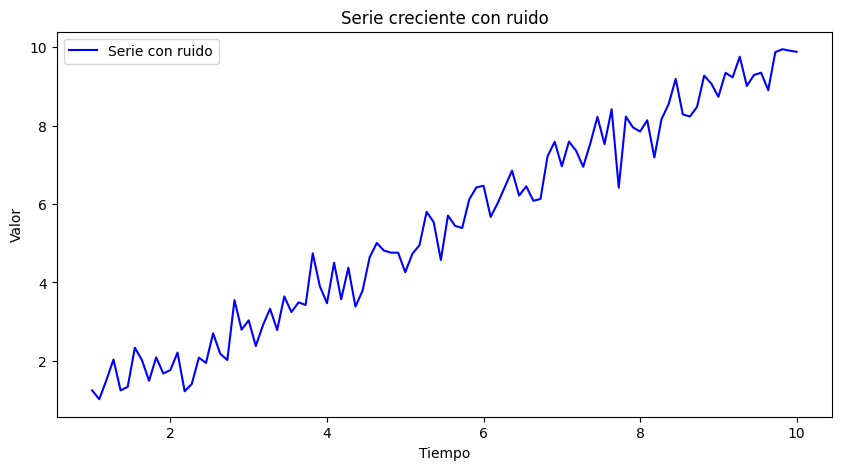

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generamos una serie creciente simple con ruido
np.random.seed(42)
x_series = np.linspace(1, 10, 100)
noise = np.random.normal(0, 0.5, x_series.shape)
y_series = x_series + noise

# Graficamos la serie generada
plt.figure(figsize=(10, 5))
plt.plot(x_series, y_series, label='Serie con ruido', color='b')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie creciente con ruido')
plt.legend()
plt.show()


## Preparación del dataset

Necesitamos preparar los datos para que sean compatibles con PyTorch. Esto incluye convertir los datos en tensores y crear secuencias para entrenar la RNN.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convertir los datos a tensores de PyTorch
x_series_tensor = torch.tensor(y_series[:-1], dtype=torch.float32).view(-1, 1)
y_series_tensor = torch.tensor(y_series[1:], dtype=torch.float32).view(-1, 1)

# Crear un conjunto de datos y un DataLoader
dataset = TensorDataset(x_series_tensor, y_series_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

## Definimos la red recurrente

Definimos una clase que hereda de nn.Module para nuestra RNN. Utilizaremos la capa nn.LSTM proporcionada por PyTorch.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        
        # Definición de la capa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Capa lineal para mapear del espacio oculto al espacio de salida
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        # x: tamaño (batch_size, seq_length, input_size)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # Inicializar el estado oculto y la celda de memoria con ceros
        hidden = (torch.zeros(1, batch_size, self.hidden_size),
                  torch.zeros(1, batch_size, self.hidden_size))
        return hidden



### Inicialización del modelo, criterio y optimizador

Creamos una instancia del modelo, definimos la función de pérdida y el optimizador.

In [5]:
# Hiperparámetros
input_size = 1
hidden_size = 50
output_size = 1
learning_rate = 0.01
num_epochs = 200

# Inicialización del modelo
model = LSTMModel(input_size, hidden_size, output_size)

# Definición del criterio de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## Entrenamiento del modelo

Definimos el bucle de entrenamiento para actualizar los pesos del modelo.

In [6]:
# Lista para almacenar la pérdida en cada época
loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        # Redimensionar x_batch y y_batch
        x_batch = x_batch.unsqueeze(1)  # Tamaño: (batch_size, seq_length, input_size)
        y_batch = y_batch.unsqueeze(1)  # Tamaño: (batch_size, seq_length, output_size)
        
        # Inicializar el estado oculto y la celda de memoria
        hidden = model.init_hidden(x_batch.size(0))
        
        # Reiniciar el gradiente del optimizador
        optimizer.zero_grad()
        
        # Forward pass
        output, hidden = model(x_batch, hidden)
        
        # Cálculo de la pérdida
        loss = criterion(output, y_batch)
        total_loss += loss.item()
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
    
    # Almacenar la pérdida promedio
    avg_loss = total_loss / len(dataloader)
    loss_list.append(avg_loss)
    
    # Mostrar la pérdida cada 20 épocas
    if (epoch + 1) % 20 == 0:
        print(f'Época [{epoch + 1}/{num_epochs}], Pérdida: {avg_loss:.4f}')


Época [20/200], Pérdida: 0.5858
Época [40/200], Pérdida: 0.4738
Época [60/200], Pérdida: 0.4116
Época [80/200], Pérdida: 0.5645
Época [100/200], Pérdida: 0.4114
Época [120/200], Pérdida: 0.4563
Época [140/200], Pérdida: 0.4866
Época [160/200], Pérdida: 0.4912
Época [180/200], Pérdida: 0.4656
Época [200/200], Pérdida: 0.4113


### Visualizamos las curvas de entrenamiento

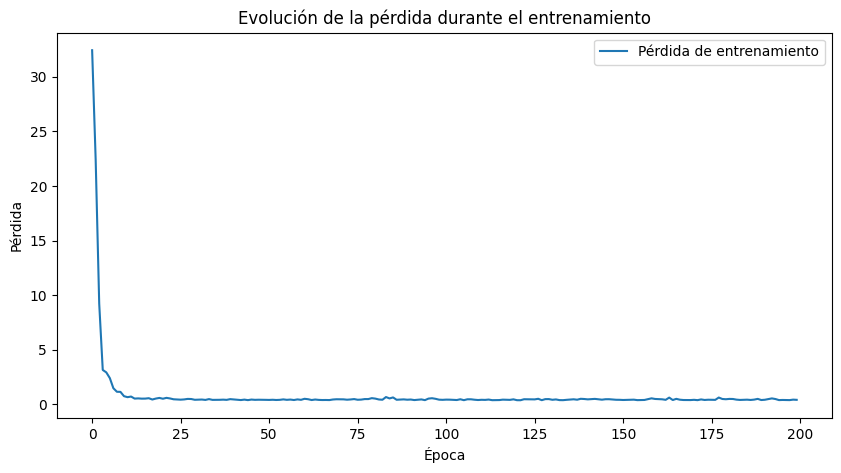

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Pérdida de entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.show()

## Evaluamos los resultados

Una vez procesada la secuencia, evaluaremos los resultados. Para esto, compararemos las salidas generadas por la RNN con los valores reales de la serie.

In [10]:
# Evaluación del modelo entrenado
model.eval()

with torch.no_grad():
    inputs = torch.tensor(y_series[:-1], dtype=torch.float32).view(-1, 1, 1)
    targets = torch.tensor(y_series[1:], dtype=torch.float32).view(-1, 1)
    
    # Inicializar el estado oculto y la celda de memoria con el tamaño de lote correcto
    hidden = model.init_hidden(inputs.size(0))
    
    # Forward pass
    outputs, hidden = model(inputs, hidden)
    outputs = outputs.view(-1).numpy()
    
    # Convertir los targets a numpy
    targets = targets.view(-1).numpy()


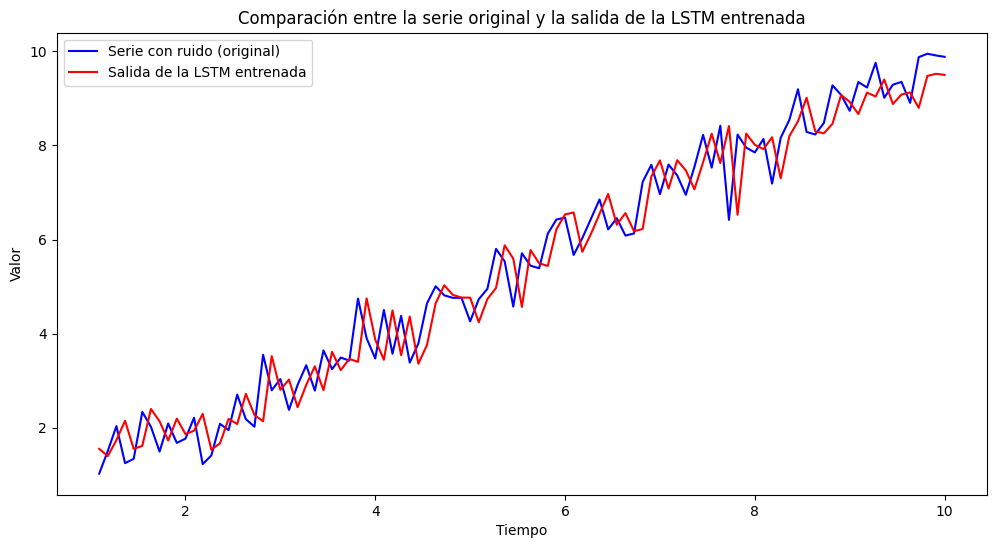

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(x_series[1:], y_series[1:], label='Serie con ruido (original)', color='b')
plt.plot(x_series[1:], outputs, label='Salida de la LSTM entrenada', color='r')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Comparación entre la serie original y la salida de la LSTM entrenada')
plt.legend()
plt.show()


## Predicción a futuro

In [12]:
# Predicción de valores futuros
future_steps = 50
predictions = []

# Usamos el último valor de entrada
last_input = torch.tensor(y_series[-1], dtype=torch.float32).view(1, 1, 1)

# Inicializar el estado oculto y la celda de memoria
hidden = model.init_hidden(1)

with torch.no_grad():
    for _ in range(future_steps):
        # Forward pass
        output, hidden = model(last_input, hidden)
        predictions.append(output.item())
        
        # La salida actual se convierte en la entrada para el próximo paso
        last_input = output.view(1, 1, 1)

Creamos el eje temporal para las predicciones futuras

In [13]:
# Calculamos el tamaño del paso temporal en la serie original
delta_t = (x_series[-1] - x_series[0]) / (len(x_series) - 1)

# Creamos un eje de tiempo extendido a partir del último valor de la serie original
t_extended = [x_series[-1] + delta_t * (i + 1) for i in range(future_steps)]



Visualizamos las predicciones

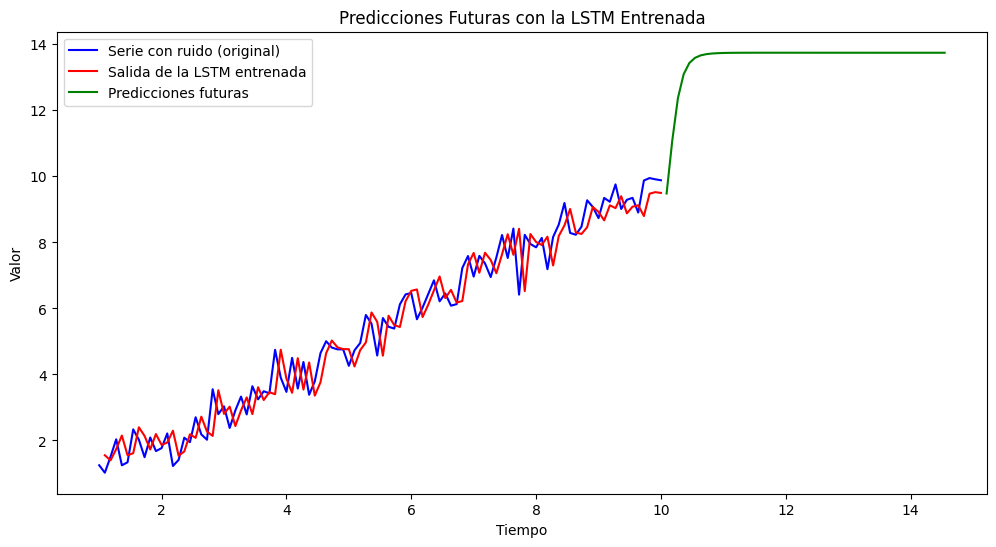

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(x_series, y_series, label='Serie con ruido (original)', color='b')
plt.plot(x_series[1:], outputs, label='Salida de la LSTM entrenada', color='r')
plt.plot(t_extended, predictions, label='Predicciones futuras', color='g')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicciones Futuras con la LSTM Entrenada')
plt.legend()
plt.show()

# Prueba con un dataset periódico (y creciente)

Ahora vamos a crear un nuevo dataset que combina una tendencia lineal con una componente sinusoidal para introducir periodicidad. Además, añadiremos algo de ruido para simular datos más realistas.

La función que vamos a utilizar es:

$$ y(t) = at+b+A\sin{(2\pi f t)} + ruido $$

Donde:

- $a$ es la pendiente de la tendencia lineal.
- $b$ es el término independiente.
- $A$ es la amplitud de la componente sinusoidal.
- $f$ es la frecuencia de la componente sinusoidal.

Frecuencia $f$: Elegimos una frecuencia de $0.05$, lo que corresponde a un periodo $T = \frac{1}{f} = 20$. Esto es menor que el tamaño de la capa oculta de la red (que será mayor a 20), cumpliendo con la condición solicitada.
Ruido: Añadimos ruido gaussiano con una desviación estándar de 2.

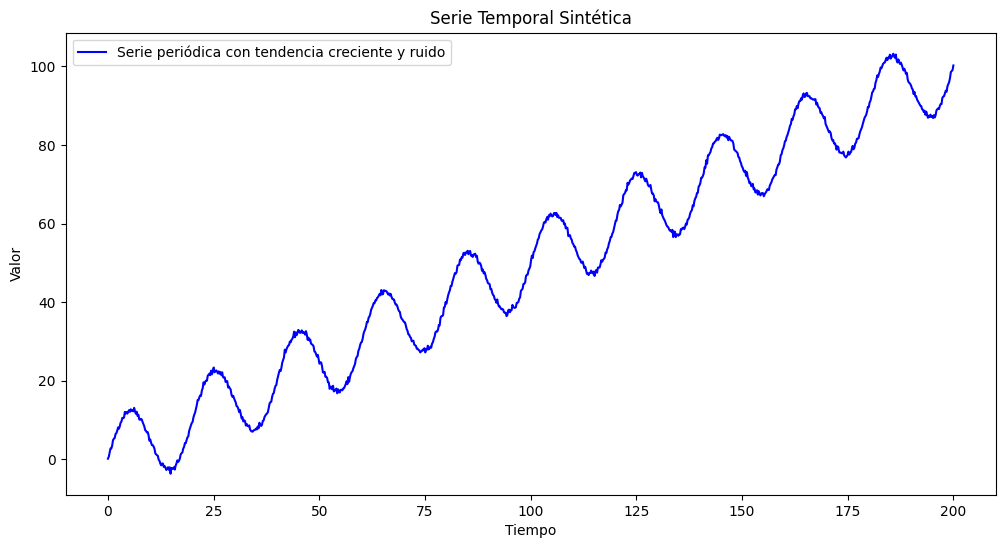

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la función
a = 0.5  # Pendiente de la tendencia lineal
b = 0    # Intercepto
A = 10   # Amplitud de la componente sinusoidal
f = 0.05 # Frecuencia (para un periodo menor que el tamaño de la capa oculta)
noise_level = 0.4  # Nivel de ruido

# Generamos la serie temporal
np.random.seed(42)
t = np.linspace(0, 200, 1000)
y_series = a * t + b + A * np.sin(2 * np.pi * f * t) + np.random.normal(0, noise_level, t.shape)

# Graficamos la serie generada
plt.figure(figsize=(12, 6))
plt.plot(t, y_series, label='Serie periódica con tendencia creciente y ruido', color='b')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal Sintética')
plt.legend()
plt.show()

### Preparación del conjunto de datos

In [40]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convertir los datos a tensores de PyTorch
x_series_tensor = torch.tensor(y_series[:-1], dtype=torch.float32).view(-1, 1)
y_series_tensor = torch.tensor(y_series[1:], dtype=torch.float32).view(-1, 1)

# Crear un conjunto de datos y un DataLoader
dataset = TensorDataset(x_series_tensor, y_series_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### Definición de la LSTM

Tamaño de la capa oculta (hidden_size): Lo establecemos en 100, que es mayor que el periodo de la señal (20), para que la red tenga suficiente capacidad para capturar las periodicidades.

In [49]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        
        # Definición de la capa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Capa lineal para mapear del espacio oculto al espacio de salida
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        # x: tamaño (batch_size, seq_length, input_size)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # Inicializar el estado oculto y la celda de memoria con ceros
        hidden = (torch.zeros(1, batch_size, self.hidden_size),
                  torch.zeros(1, batch_size, self.hidden_size))
        return hidden

## Entrenamiento

In [50]:
# Hiperparámetros
input_size = 1
hidden_size = 100  # Tamaño de la capa oculta mayor que el periodo
output_size = 1
learning_rate = 0.001
num_epochs = 500
num_layers = 1

# Inicialización del modelo
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Definición del criterio de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [51]:
# Lista para almacenar la pérdida en cada época
loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        # Redimensionar x_batch y y_batch
        x_batch = x_batch.unsqueeze(1)  # Tamaño: (batch_size, seq_length, input_size)
        y_batch = y_batch.unsqueeze(1)  # Tamaño: (batch_size, seq_length, output_size)
        
        # Inicializar el estado oculto y la celda de memoria, eniendo en cuenta num_layers
        hidden = model.init_hidden(x_batch.size(0))
        
        # Reiniciar el gradiente del optimizador
        optimizer.zero_grad()
        
        # Forward pass
        output, hidden = model(x_batch, hidden)
        
        # Cálculo de la pérdida
        loss = criterion(output, y_batch)
        total_loss += loss.item()
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
    
    # Almacenar la pérdida promedio
    avg_loss = total_loss / len(dataloader)
    loss_list.append(avg_loss)
    
    # Mostrar la pérdida cada 50 épocas
    if (epoch + 1) % 50 == 0:
        print(f'Época [{epoch + 1}/{num_epochs}], Pérdida: {avg_loss:.4f}')


Época [50/500], Pérdida: 70.6871
Época [100/500], Pérdida: 6.8872
Época [150/500], Pérdida: 1.5355
Época [200/500], Pérdida: 0.7632
Época [250/500], Pérdida: 0.6235
Época [300/500], Pérdida: 0.5989
Época [350/500], Pérdida: 0.5979
Época [400/500], Pérdida: 0.5861
Época [450/500], Pérdida: 0.5611
Época [500/500], Pérdida: 0.5701


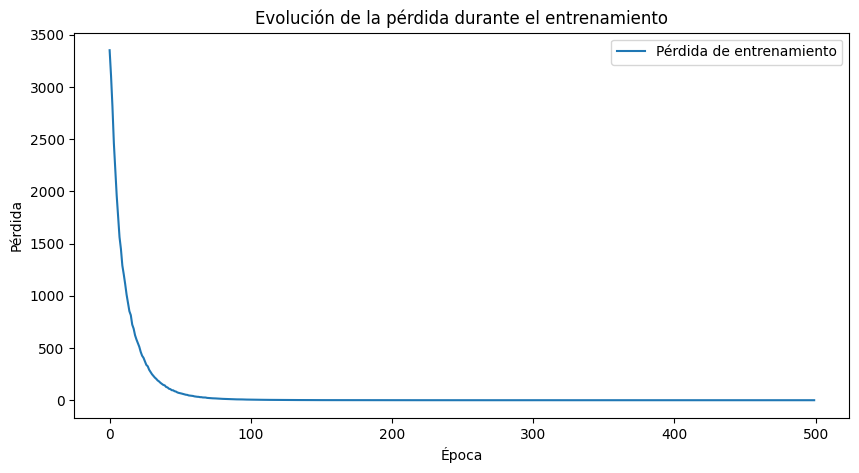

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Pérdida de entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.show()

## Evaluación del modelo

In [53]:
# Desactivar el modo de entrenamiento
model.eval()

with torch.no_grad():
    inputs = torch.tensor(y_series[:-1], dtype=torch.float32).view(-1, 1, 1)
    targets = torch.tensor(y_series[1:], dtype=torch.float32).view(-1, 1)
    
    # Inicializar el estado oculto y la celda de memoria con el tamaño de lote correcto
    hidden = model.init_hidden(inputs.size(0))
    
    # Forward pass
    outputs, hidden = model(inputs, hidden)
    outputs = outputs.view(-1).numpy()
    
    # Convertir los targets a numpy
    targets = targets.view(-1).numpy()


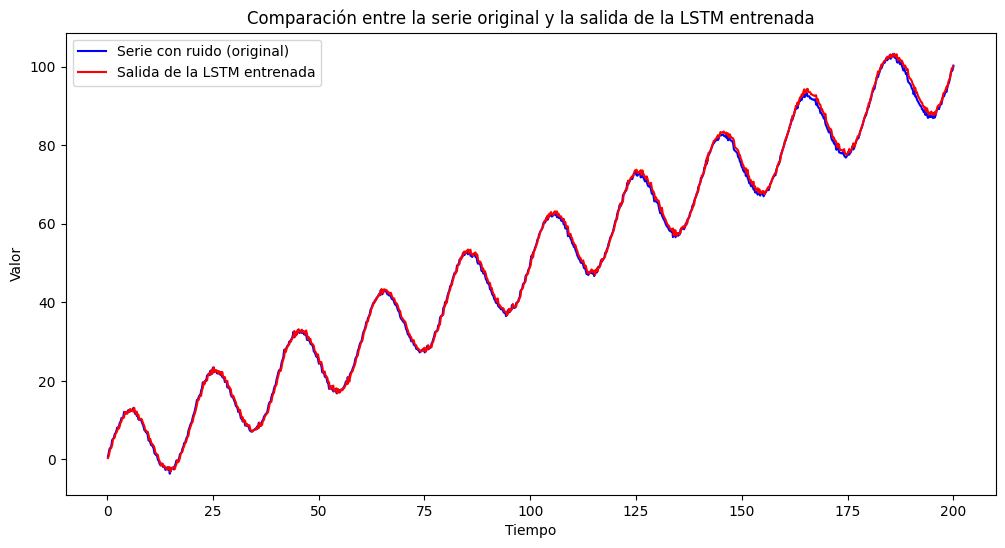

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(t[1:], y_series[1:], label='Serie con ruido (original)', color='b')
plt.plot(t[1:], outputs, label='Salida de la LSTM entrenada', color='r')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Comparación entre la serie original y la salida de la LSTM entrenada')
plt.legend()
plt.show()


## Predicción de valores futuros

In [55]:
# Predicción de valores futuros
future_steps = 200
predictions = []

# Usamos el último valor de entrada
last_input = torch.tensor(y_series[-1], dtype=torch.float32).view(1, 1, 1)

# Inicializar el estado oculto y la celda de memoria para batch_size=1
hidden = model.init_hidden(1)

with torch.no_grad():
    for _ in range(future_steps):
        # Forward pass
        output, hidden = model(last_input, hidden)
        predictions.append(output.item())
        
        # La salida actual se convierte en la entrada para el próximo paso
        last_input = output.view(1, 1, 1)

In [56]:
# Calculamos el tamaño del paso temporal en la serie original
delta_t = (t[-1] - t[0]) / (len(t) - 1)

# Creamos un eje de tiempo extendido a partir del último valor de la serie original
t_extended = [t[-1] + delta_t * (i + 1) for i in range(future_steps)]

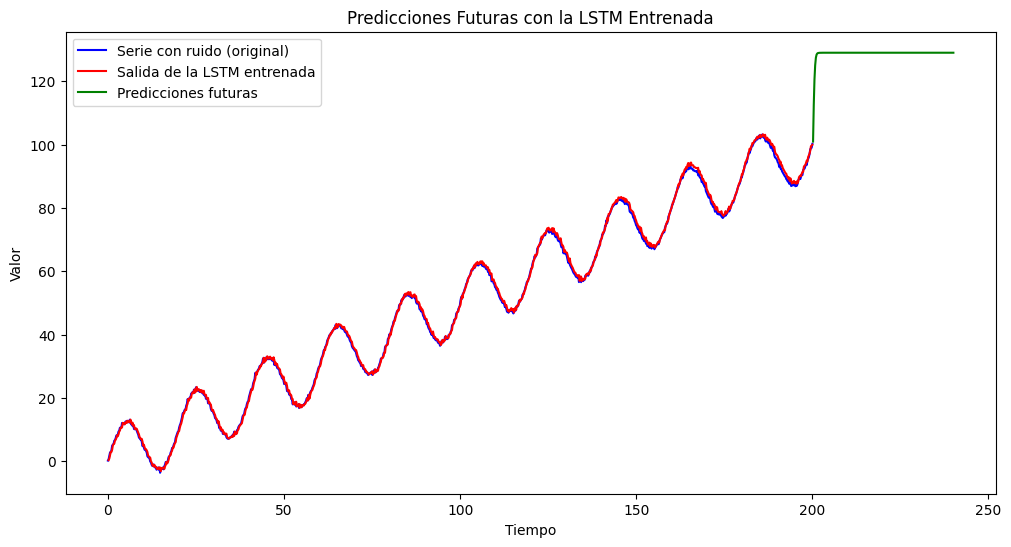

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(t, y_series, label='Serie con ruido (original)', color='b')
plt.plot(t[1:], outputs, label='Salida de la LSTM entrenada', color='r')
plt.plot(t_extended, predictions, label='Predicciones futuras', color='g')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicciones Futuras con la LSTM Entrenada')
plt.legend()
plt.show()

# Modelo más complejo y normalización de datos

Vamos a probar a meter más capas y a normalizar los datos de entrada

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

## VOLVEMOS A GENERAR LOS DATOS
# Parámetros de la función
a = 0.5  # Pendiente de la tendencia lineal
b = 0    # Intercepto
A = 10   # Amplitud de la componente sinusoidal
f = 0.05 # Frecuencia (para un periodo menor que el tamaño de la capa oculta)
noise_level = 2  # Nivel de ruido

# Generamos la serie temporal
np.random.seed(42)
t = np.linspace(0, 200, 1000)
y_series = a * t + b + A * np.sin(2 * np.pi * f * t) + np.random.normal(0, noise_level, t.shape)

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
y_series_scaled = scaler.fit_transform(y_series.reshape(-1, 1)).flatten()


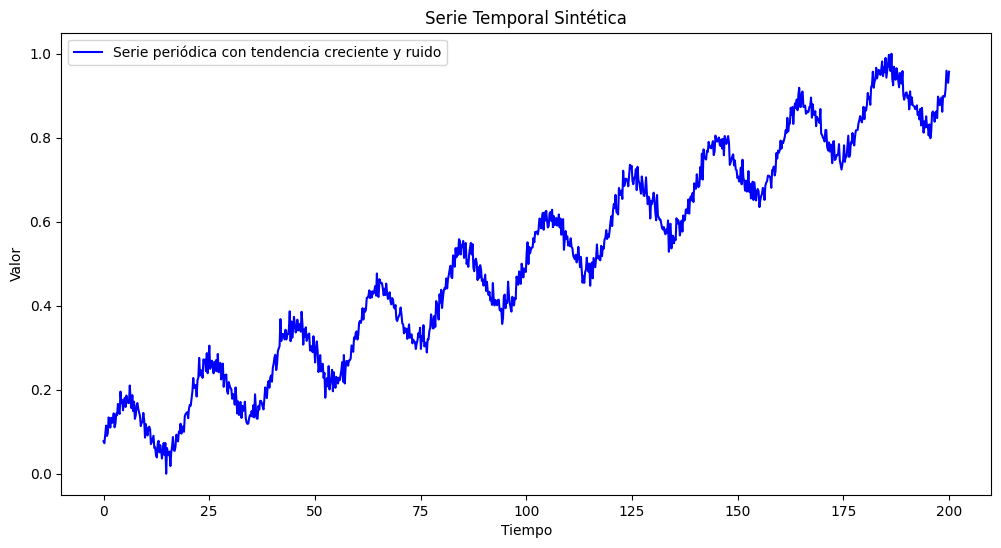

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(t, y_series_scaled, label='Serie periódica con tendencia creciente y ruido', color='b')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal Sintética')
plt.legend()
plt.show()

In [72]:
# Función para crear secuencias
# Preparación del conjunto de datos con secuencias
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
X, y = create_sequences(y_series_scaled, seq_length)


In [73]:
# Preparación de los datos para PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_tensor = X_tensor.view(-1, seq_length, 1)

dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Definimos el modelo de 3 capas

In [74]:
# Definición del modelo LSTM con 3 capas ocultas
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=3, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = out[:, -1, :]  # (batch_size, hidden_size)
        out = self.fc(out)   # (batch_size, output_size)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers, batch_size, self.hidden_size))
        return hidden

### Entrenamos

In [ ]:
# Inicialización del modelo, criterio y optimizador
input_size = 1
hidden_size = 100
num_layers = 3
output_size = 1
learning_rate = 0.001
num_epochs = 100

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [76]:
# Entrenamiento del modelo
loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        batch_size = X_batch.size(0)
        
        hidden = model.init_hidden(batch_size)
        
        optimizer.zero_grad()
        
        output, hidden = model(X_batch, hidden)
        
        # Ajustar las formas
        y_batch = y_batch.view(-1, 1)  # (batch_size, 1)
        
        # Calcular la pérdida
        loss = criterion(output, y_batch)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(dataloader)
    loss_list.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f'Época [{epoch + 1}/{num_epochs}], Pérdida: {avg_loss:.4f}')

Época [20/200], Pérdida: 0.0008
Época [40/200], Pérdida: 0.0005
Época [60/200], Pérdida: 0.0005
Época [80/200], Pérdida: 0.0006
Época [100/200], Pérdida: 0.0005
Época [120/200], Pérdida: 0.0004
Época [140/200], Pérdida: 0.0004
Época [160/200], Pérdida: 0.0005
Época [180/200], Pérdida: 0.0005
Época [200/200], Pérdida: 0.0005


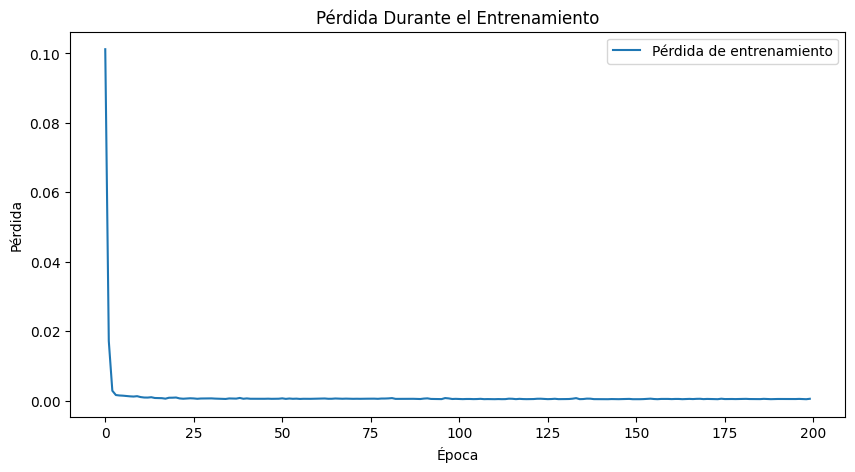

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Pérdida de entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida Durante el Entrenamiento')
plt.legend()
plt.show()

## Evaluación

In [78]:
with torch.no_grad():
    X_eval = torch.tensor(X, dtype=torch.float32)
    y_eval = y
    X_eval = X_eval.view(-1, seq_length, 1)
    
    hidden = model.init_hidden(X_eval.size(0))
    
    outputs, hidden = model(X_eval, hidden)
    outputs = outputs.squeeze().numpy()
    
    outputs = scaler.inverse_transform(outputs.reshape(-1, 1)).flatten()
    targets = scaler.inverse_transform(y_eval.reshape(-1, 1)).flatten()

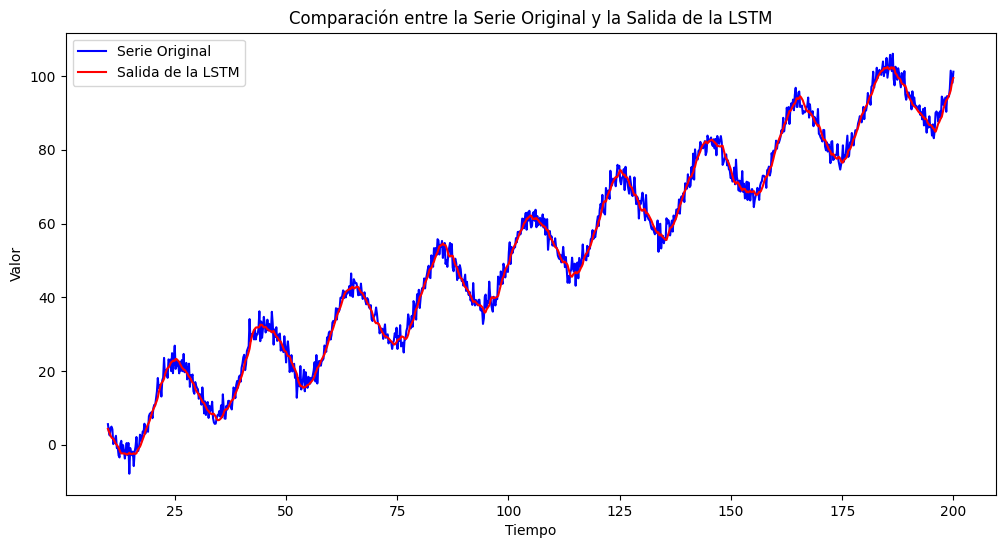

In [80]:
# Ajustar el eje de tiempo
t_new = t[seq_length:]  # Desde el final de la primera secuencia en adelante

plt.figure(figsize=(12, 6))
plt.plot(t_new, targets, label='Serie Original', color='b')
plt.plot(t_new, outputs, label='Salida de la LSTM', color='r')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Comparación entre la Serie Original y la Salida de la LSTM')
plt.legend()
plt.show()

## Predicción de valores futuros

In [86]:
# Número de pasos futuros a predecir
future_steps = 200

# Inicializar la entrada con la última secuencia de los datos de entrenamiento
last_sequence = X_tensor[-1].unsqueeze(0)  # Forma: (1, seq_length, 1)

# Inicializar el estado oculto
hidden = model.init_hidden(1)

# Almacenar las predicciones
predictions = []

with torch.no_grad():
    for _ in range(future_steps):
        # Forward pass
        output, hidden = model(last_sequence, hidden)
        
        # Redimensionar la salida para que coincida con la forma de entrada
        next_input = output.view(1, 1, -1)  # Forma: (1, 1, input_size)
        
        # Actualizar la secuencia de entrada
        last_sequence = torch.cat((last_sequence[:, 1:, :], next_input), dim=1)
        
        # Guardar la predicción
        predictions.append(output.item())


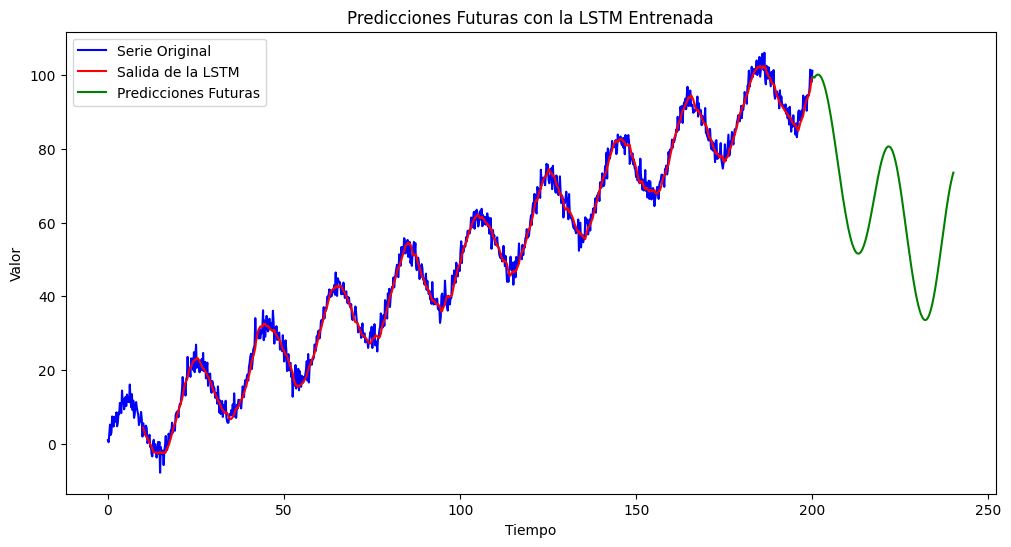

In [88]:
# Transformar las predicciones a la escala original
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Crear el eje de tiempo extendido para las predicciones futuras
delta_t = (t[-1] - t[0]) / (len(t) - 1)
t_future = [t[-1] + delta_t * (i + 1) for i in range(future_steps)]

plt.figure(figsize=(12, 6))
plt.plot(t, y_series, label='Serie Original', color='b')
plt.plot(t_new, outputs, label='Salida de la LSTM', color='r')
plt.plot(t_future, predictions, label='Predicciones Futuras', color='g')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicciones Futuras con la LSTM Entrenada')
plt.legend()
plt.show()

# LSTM con output_size = 50

## Generamos los datos  nuevamente

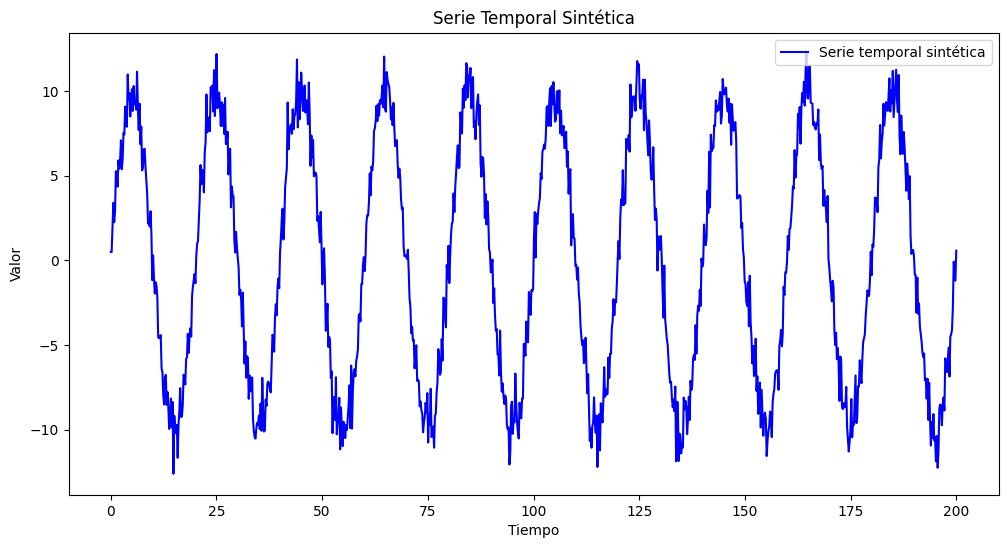

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Parámetros de la función
a = 0.0   # Pendiente de la tendencia lineal
b = 0     # Intercepto
A = 10    # Amplitud de la componente sinusoidal
f = 0.05  # Frecuencia
noise_level = 1  # Nivel de ruido

# Generamos la serie temporal
np.random.seed(42)
t = np.linspace(0, 200, 1000)
y_series = a * t + b + A * np.sin(2 * np.pi * f * t) + np.random.normal(0, noise_level, t.shape)

# Graficamos la serie generada
plt.figure(figsize=(12, 6))
plt.plot(t, y_series, label='Serie temporal sintética', color='b')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal Sintética')
plt.legend()
plt.show()

In [120]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
y_series_scaled = scaler.fit_transform(y_series.reshape(-1, 1)).flatten()

def create_input_output_sequences(data, input_length, output_length):
    xs = []
    ys = []
    for i in range(len(data) - input_length - output_length + 1):
        x = data[i:(i + input_length)]
        y = data[(i + input_length):(i + input_length + output_length)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50   # Longitud de las secuencias de entrada
output_size = 50  # Longitud de las secuencias de salida (número de pasos a predecir)

X, y = create_input_output_sequences(y_series_scaled, seq_length, output_size)

# Convertir a tensores de PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Redimensionar entradas y salidas
X_tensor = X_tensor.view(-1, seq_length, 1)          # Forma: (batch_size, seq_length, input_size)
y_tensor = y_tensor.view(-1, output_size)            # Forma: (batch_size, output_size)

# Crear Dataset y DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Definimos el modelo

In [121]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=3, output_size=50):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Definir la capa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Definir la capa de salida para mapear del estado oculto al output_size
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        # x: (batch_size, seq_length, input_size)
        out, hidden = self.lstm(x, hidden)
        # Obtener la salida del último paso de tiempo
        out = out[:, -1, :]      # (batch_size, hidden_size)
        out = self.fc(out)       # (batch_size, output_size)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # Inicializar estado oculto y de celda con ceros
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers, batch_size, self.hidden_size))
        return hidden


## Entrenamiento y evaluación

In [122]:
# Hiperparámetros
input_size = 1
hidden_size = 100
num_layers = 3
learning_rate = 0.001
num_epochs = 100

# Inicialización del modelo
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Definición de la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [123]:
# Lista para almacenar la pérdida en cada época
loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        batch_size = X_batch.size(0)
        
        # Inicializar el estado oculto
        hidden = model.init_hidden(batch_size)
        
        # Reiniciar gradientes
        optimizer.zero_grad()
        
        # Forward pass
        output, hidden = model(X_batch, hidden)
        
        # Calcular la pérdida
        loss = criterion(output, y_batch)
        total_loss += loss.item()
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(dataloader)
    loss_list.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f'Época [{epoch + 1}/{num_epochs}], Pérdida: {avg_loss:.6f}')

Época [20/100], Pérdida: 0.001696
Época [40/100], Pérdida: 0.001677
Época [60/100], Pérdida: 0.001898
Época [80/100], Pérdida: 0.001693
Época [100/100], Pérdida: 0.001688


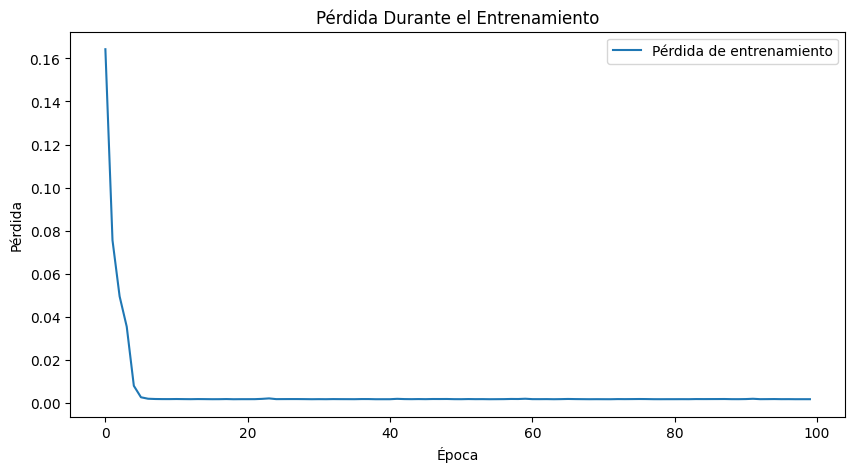

In [124]:
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Pérdida de entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida Durante el Entrenamiento')
plt.legend()
plt.show()

In [125]:
# Desactivar el modo de entrenamiento
model.eval()

with torch.no_grad():
    X_eval = torch.tensor(X, dtype=torch.float32)
    y_eval = y
    X_eval = X_eval.view(-1, seq_length, 1)
    
    batch_size = X_eval.size(0)
    hidden = model.init_hidden(batch_size)
    
    outputs, hidden = model(X_eval, hidden)
    outputs = outputs.numpy()
    
    targets = y_eval

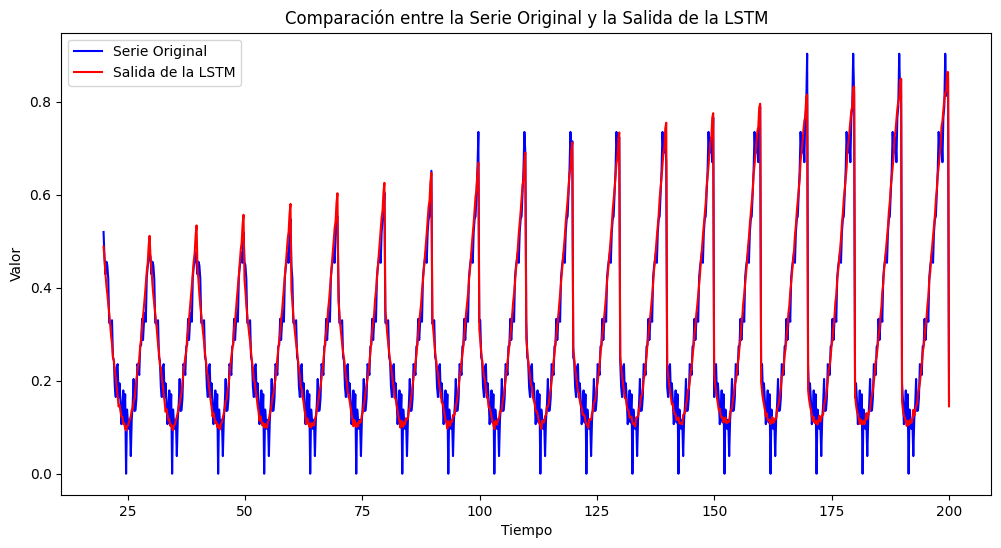

In [126]:
# Ajustar el eje de tiempo
t_new = t[seq_length + output_size - 1:]

# Aplanar las matrices de predicciones y targets
outputs_flat = outputs.flatten()
targets_flat = targets.flatten()

# Asegurar que t_new, outputs_flat y targets_flat tengan la misma longitud
min_len = min(len(t_new), len(outputs_flat), len(targets_flat))
t_new = t_new[:min_len]
outputs_flat = outputs_flat[:min_len]
targets_flat = targets_flat[:min_len]

plt.figure(figsize=(12, 6))
plt.plot(t_new, targets_flat, label='Serie Original', color='b')
plt.plot(t_new, outputs_flat, label='Salida de la LSTM', color='r')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Comparación entre la Serie Original y la Salida de la LSTM')
plt.legend()
plt.show()

## Predicción a futuro

In [127]:
# Predicción de valores futuros
future_sequences = 4  # Número de secuencias de 50 pasos a predecir
predictions = []

# Usamos la última secuencia de entrenamiento como punto de partida
last_sequence = X_tensor[-1].unsqueeze(0)  # Forma: (1, seq_length, 1)

model.eval()
with torch.no_grad():
    hidden = model.init_hidden(1)
    for _ in range(future_sequences):
        # Forward pass
        output, hidden = model(last_sequence, hidden)
        
        # Guardar las predicciones
        predictions.extend(output.numpy().flatten())
        
        # Preparar la siguiente secuencia de entrada
        # Extraer los últimos `seq_length` valores de las predicciones acumuladas
        predicted_values = torch.tensor(predictions[-seq_length:], dtype=torch.float32).view(1, seq_length, 1)
        last_sequence = predicted_values

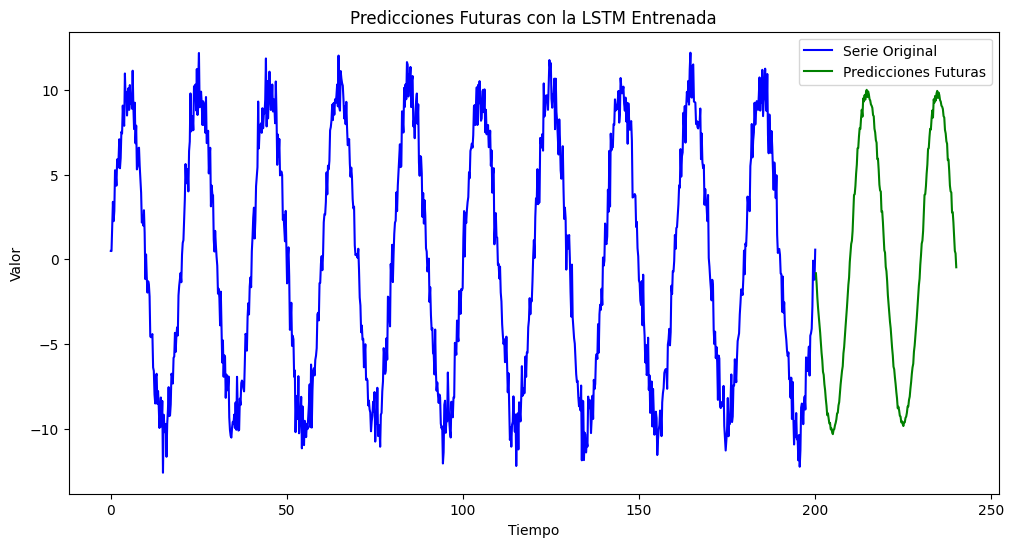

In [128]:
# Transformar las predicciones a la escala original
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Crear el eje de tiempo extendido para las predicciones futuras
delta_t = (t[-1] - t[0]) / (len(t) - 1)
t_future = [t[-1] + delta_t * (i + 1) for i in range(len(predictions))]

plt.figure(figsize=(12, 6))
plt.plot(t, y_series, label='Serie Original', color='b')
plt.plot(t_future, predictions, label='Predicciones Futuras', color='g')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicciones Futuras con la LSTM Entrenada')
plt.legend()
plt.show()